Imports & setup

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


Load dataset

In [3]:
# Path to dataset
DATA_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

# Load CSV
df = pd.read_csv(DATA_PATH)

# Basic check
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Dataset overview

In [4]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
df.info()

Dataset shape: (10000, 14)

Column info:
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  str    
 2   Type                     10000 non-null  str    
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64 

Summary statistics

In [5]:
df.describe(include="all")

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


Missing values check

In [6]:
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

Target variable distribution

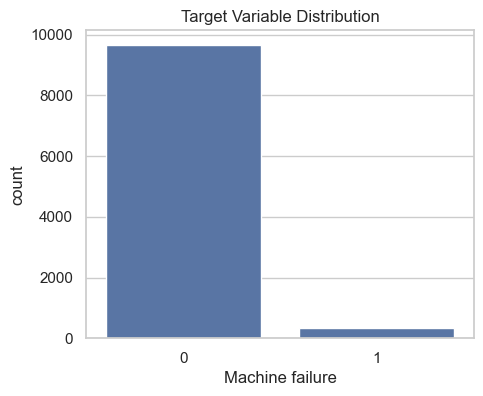

In [7]:
# Assuming 'Machine failure' is the target
target_col = "Machine failure"

df[target_col].value_counts(normalize=True)

plt.figure(figsize=(5, 4))
sns.countplot(x=target_col, data=df)
plt.title("Target Variable Distribution")
plt.show()

Numerical feature distributions

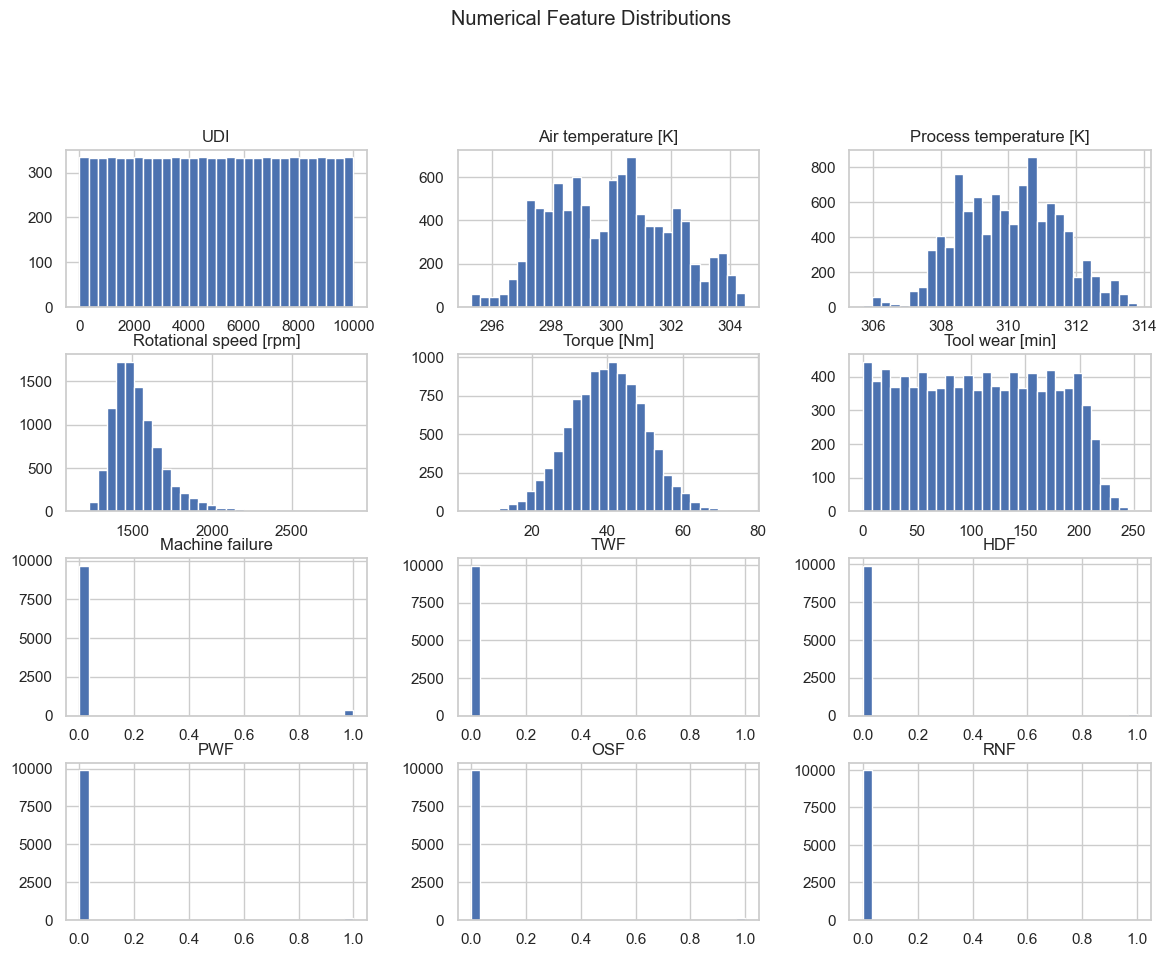

In [8]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols

df[numerical_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Numerical Feature Distributions", y=1.02)
plt.show()

Correlation analysis

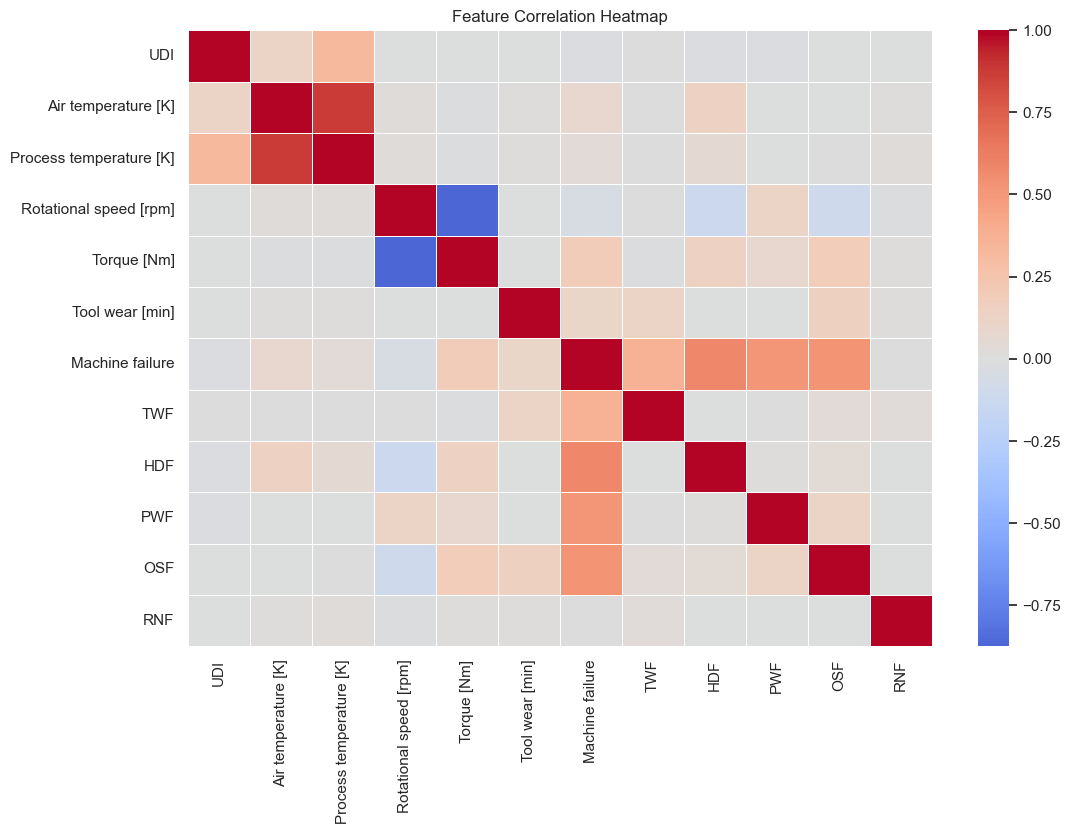

In [9]:
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.show()

Failure vs key features

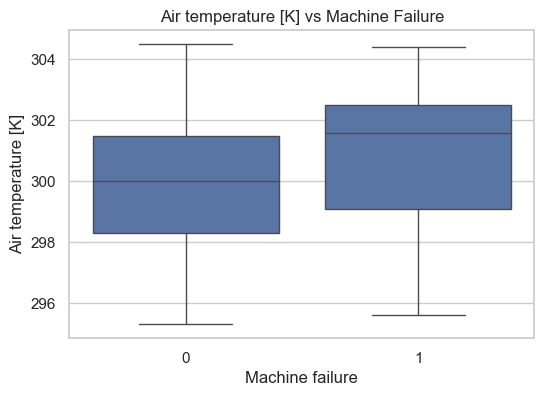

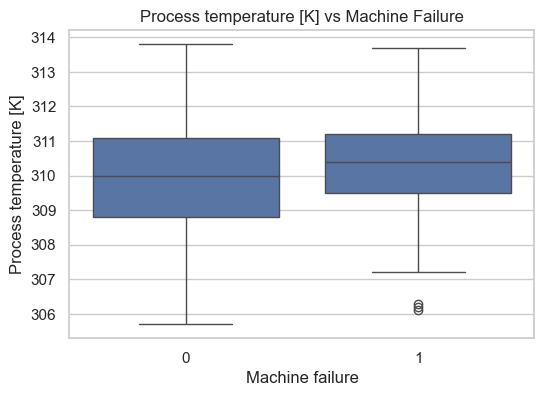

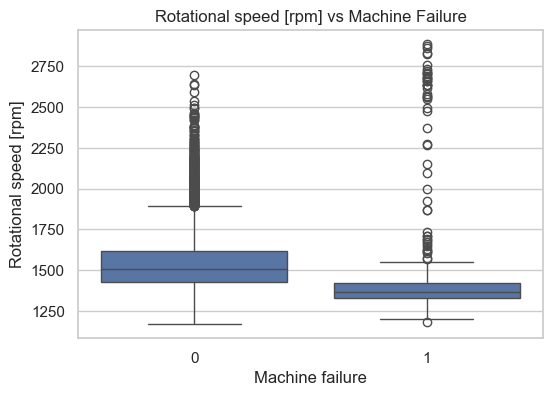

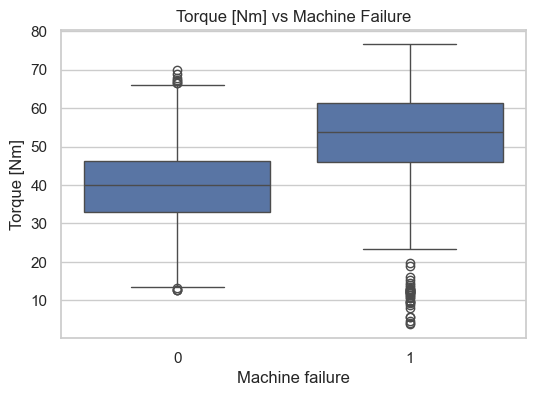

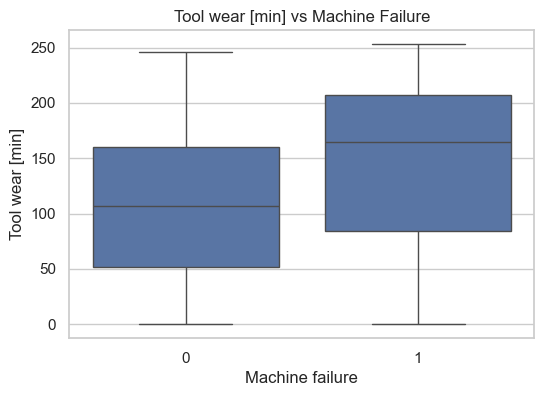

In [10]:
key_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=feature, data=df)
    plt.title(f"{feature} vs Machine Failure")
    plt.show()

Basic preprocessing

In [11]:
# Drop ID columns if present
id_cols = [col for col in df.columns if "id" in col.lower()]
df_clean = df.drop(columns=id_cols)

print("Dropped ID columns:", id_cols)
print("Clean dataset shape:", df_clean.shape)

Dropped ID columns: ['Product ID']
Clean dataset shape: (10000, 13)


Save cleaned dataset

In [12]:
# OUTPUT_PATH = "../data/ai4i_2020_cleaned.csv"
# df_clean.to_csv(OUTPUT_PATH, index=False)

# print("Cleaned dataset saved to:", OUTPUT_PATH)